In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from submission.source.constants import COLUMN_TYPES
from submission.source.helpers import load_data, get_confusion_matrix, eval_metrics

sns.set_style()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# sklearn.set_config(transform_output="pandas")

## Load data

In [4]:
credit_df = load_data()

Loading dataset...
Dataset has been loaded! Shape: (1000, 22)


## Define preprocessor

In [5]:
feature_types = {i:COLUMN_TYPES[i] for i in COLUMN_TYPES if i != 'default'}

columns_to_scale = [key for key in feature_types.keys() if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

columns_to_encode = [key for key in feature_types.keys() if feature_types[key] == "category"]
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, columns_to_scale),
    ('cat', categorical_transformer, columns_to_encode)
])

## Define pipeline

In [6]:
pipeline_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

## Split data

In [7]:
X = credit_df.drop(columns="default")
Y = credit_df['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=30, stratify=Y)

## Baseline results

In [8]:
pipeline_baseline.fit(X_train, Y_train)
acc, f1 = eval_metrics(Y_test, pipeline_baseline.predict(X_test))

print(f"[Baseline] accuracy: {acc}, F1: {f1}")

[Baseline] accuracy: 0.755, F1: 0.697819987049428


/home/nikita/PycharmProjects/GisardTechExercise/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


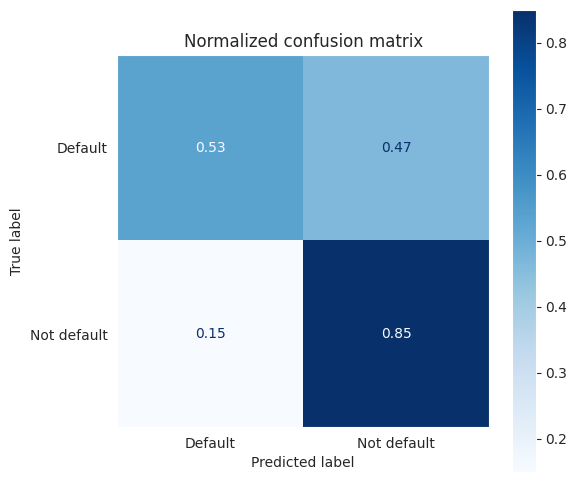

In [9]:
get_confusion_matrix(pipeline_baseline, X_test, Y_test)
plt.show()

## First approach: Random over-sampling

In [10]:
from imblearn.over_sampling import RandomOverSampler

In [11]:
pipeline_random_oversampling = PipelineImb(steps=[
    ('preprocessor', preprocessor),
    ("resampler", RandomOverSampler(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [12]:
pipeline_random_oversampling.fit(X_train, Y_train)
acc, f1 = eval_metrics(Y_test, pipeline_random_oversampling.predict(X_test))

print(f"[Random over-sampling] accuracy: {acc}, F1: {f1}")

[Random over-sampling] accuracy: 0.71, F1: 0.6906666666666668


/home/nikita/PycharmProjects/GisardTechExercise/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


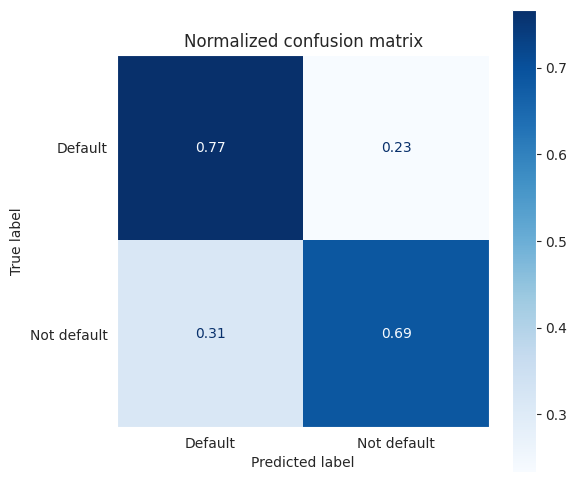

In [13]:
get_confusion_matrix(pipeline_random_oversampling, X_test, Y_test)
plt.show()


## Second approach: SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
pipeline_smote = PipelineImb(steps=[
    ('preprocessor', preprocessor),
    ("resampler", SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [16]:
pipeline_smote.fit(X_train, Y_train)
acc, f1 = eval_metrics(Y_test, pipeline_smote.predict(X_test))

print(f"[SMOTE] accuracy: {acc}, F1: {f1}")

[SMOTE] accuracy: 0.725, F1: 0.7058744886226903


/home/nikita/PycharmProjects/GisardTechExercise/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


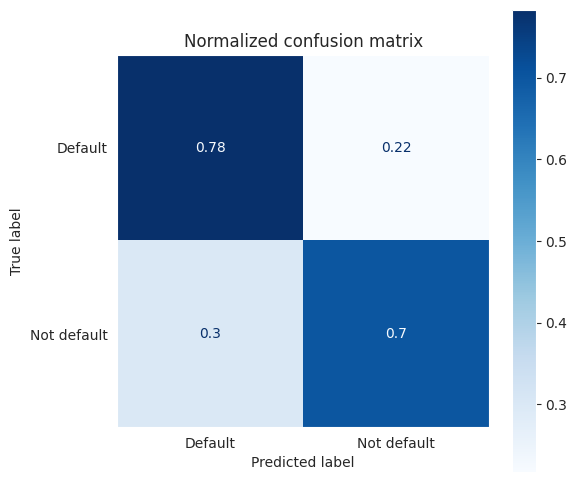

In [17]:
get_confusion_matrix(pipeline_smote, X_test, Y_test)
plt.show()